In [8]:
import collections
import csv
import keras
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import time
import shap
import ROOT as root
from sklearn.preprocessing import StandardScaler

from keras import optimizers
from keras.regularizers import l2

from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add
from keras import activations

from ROOT import TFile, TLorentzVector

from tools.constants import *

In [9]:
""" Data augmentation. """
def random_rotation(X,deltas_phi,num_vectors,met):

    for i in range(num_vectors):
        
        R = np.sqrt((X[:,4*i+0]**2 + X[:,4*i+1]**2))
        old_phis = np.arctan2(X[:,4*i+1],X[:,4*i+0])
        new_phis = old_phis + deltas_phi

        angles_sin = np.sin(new_phis)
        angles_cos = np.cos(new_phis)

        X[:,4*i+0] = angles_cos * R
        X[:,4*i+1] = angles_sin * R
        
    if met:
        return random_rotation_MET(X, deltas_phi)
    else:
        return X


def random_rotation_MET(X, deltas_phi):

    R = np.sqrt((X[:,-11]**2 + X[:,-10]**2))
    old_phis = np.arctan2(X[:,-10],(X[:,-11]))
    new_phis = old_phis + deltas_phi

    angles_sin = np.sin(new_phis)
    angles_cos = np.cos(new_phis)

    X[:,-11] = angles_cos * R
    X[:,-10] = angles_sin * R

    return X


def data_rotation(X, num_vectors_X = 11, met = True):
    
    deltas_phi = np.random.rand(X.shape[0])*2*math.pi
    X = random_rotation(X,deltas_phi,num_vectors_X,met)
        
    return X

""" Data generator for serving the NN data. """
# modified from source: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, scaler = ["scaler_params/X_scaler_mass_reco_narrow_btags.csv","scaler_params/y_scaler_higgs_masses_narrow_btags.csv"], batch_size=32, n_features=76, shuffle=True, augmentation = True, ceil = False):
        self.n_features = n_features
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.ceil = ceil
        self.indexes = np.arange(len(X))
        with open(scaler[0]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.X_scaler = scaler_params[0:2,:]
        with open(scaler[1]) as f:
            scaler_params = np.loadtxt(f, delimiter=",")
            self.y_scaler = scaler_params[0:2]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.ceil:
            return int(np.ceil(len(self.X) / self.batch_size))
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y, weights = self.__data_generation(indexes)
        return X, y, weights

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)

        X = self.X[indexes]

        weights = X[:,-1]
        X = X[:,:-1]

        y = self.y[indexes]

        if self.augmentation:
            X = data_rotation(X, num_vectors_X = 11, met = True)
        X = (X-self.X_scaler[0])/self.X_scaler[1]     # Standardize
        y = (y-self.y_scaler[0])/self.y_scaler[1]     # Standardize

        return X, y, weights
    
    def get_all(self):
        'Get all data - all batches.'
        X = []
        y = []

        for i in range(self.__len__()):
            X_y = self.__getitem__(i)
            X += X_y[0].tolist()
            y += X_y[1].tolist()

        X = np.array(X)
        y = np.array(y)
        
        return X, y

In [10]:
# Load data.

def add_weights(tth,ttz):
    """ Class weights, because of the imbalance between the productions' number of events. """
    weight_tth = 1/(2*len(tth)/(len(ttz)+len(tth)))
    weight_ttz = 1/(2*len(ttz)/(len(ttz)+len(tth)))

    print(weight_tth)
    print(weight_ttz)

    ones = np.ones((tth.shape[0],1))
    tth = np.concatenate((tth, weight_tth*ones),axis=1)

    ones = np.ones((ttz.shape[0],1))
    ttz = np.concatenate((ttz, weight_ttz*ones),axis=1)

    return tth,ttz

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_train_ttH.csv") as f: 
    X_y_train_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_train_ttZ.csv") as f: 
    X_y_train_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_test_ttH.csv") as f: 
    X_y_test_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_test_ttZ.csv") as f: 
    X_y_test_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)

with open("data/mass_reco/mass_reco_input_narrow_selection_btags_val_ttH.csv") as f: 
    X_y_val_ttH = np.loadtxt(f, delimiter=",", skiprows=1)
with open("data/mass_reco/mass_reco_input_narrow_selection_btags_val_ttZ.csv") as f: 
    X_y_val_ttZ = np.loadtxt(f, delimiter=",", skiprows=1)


X_y_train_ttH, X_y_train_ttZ = add_weights(X_y_train_ttH, X_y_train_ttZ)    # Add weights to the data
X_y_train = np.concatenate((X_y_train_ttH, X_y_train_ttZ), axis=0)          # Combine ttH and ttZ for training.
X_train = np.concatenate((X_y_train[:,:-10], X_y_train[:,-6:]), axis = 1)   # Seprate X ...
y_train = X_y_train[:,-10:-6]                                               # ... and y.
y_train_masses = np.empty((y_train.shape[0],1))                             # From y we will calculate masses - we use those as labels.

vec = TLorentzVector(0,0,0,0)
for i in range(len(y_train)):              # For each event calculate the Higgs/Z boson mass.
    v = y_train[i]
    vec.SetPxPyPzE(v[0],v[1],v[2],v[3])
    y_train_masses[i] = vec.Mag()

X_y_val_ttH, X_y_val_ttZ = add_weights(X_y_val_ttH, X_y_val_ttZ)    # Repeat for val and test...
X_y_val = np.concatenate((X_y_val_ttH, X_y_val_ttZ), axis=0)
X_val = np.concatenate((X_y_val[:,:-10], X_y_val[:,-6:]), axis = 1)   
y_val = X_y_val[:,-10:-6]
y_val_masses = np.empty((y_val.shape[0],1))

vec = TLorentzVector(0,0,0,0)
for i in range(len(y_val)):
    v = y_val[i]
    vec.SetPxPyPzE(v[0],v[1],v[2],v[3])
    y_val_masses[i] = vec.Mag()

X_y_test_ttH, X_y_test_ttZ = add_weights(X_y_test_ttH, X_y_test_ttZ)
X_y_test = np.concatenate((X_y_test_ttH, X_y_test_ttZ), axis=0)
X_test = np.concatenate((X_y_test[:,:-10], X_y_test[:,-6:]), axis = 1)  
y_test = X_y_test[:,-10:-6]
y_test_masses = np.empty((y_test.shape[0],1))

vec = TLorentzVector(0,0,0,0)
for i in range(len(y_test)):
    v = y_test[i]
    vec.SetPxPyPzE(v[0],v[1],v[2],v[3])
    y_test_masses[i] = vec.Mag()

num_features = X_train.shape[1]-1   # exclude weights
num_samples = X_train.shape[0]

print(num_features,num_samples)

0.8002137488795421
1.3327400091869543
0.8011647254575707
1.330110497237569
0.8
1.3333333333333333
76 23211


In [11]:
train_generator = DataGenerator(X_train, y_train_masses, n_features = num_features, batch_size=4096, shuffle=True, augmentation = True, ceil = False)
val_generator = DataGenerator(X_val, y_val_masses, n_features = num_features, batch_size=128, shuffle=False, augmentation = False, ceil = True)
test_generator = DataGenerator(X_test, y_test_masses, n_features = num_features, batch_size=128, shuffle=False, augmentation = False, ceil = True)

In [12]:
""" Get scaler params... """
""" X_train = np.empty((num_samples,num_features), dtype=float)
y_train_masses = np.empty((num_samples,1), dtype=float)
c = 0

for i in range(len(train_generator)):
    rows = len(train_generator[i][0][:])

    X_train[c:c+rows,:] = train_generator[i][0][:]
    y_train_masses[c:c+rows,:] = train_generator[i][1][:]
    c += rows

X_train = X_train[1:,:]
y_train_masses = y_train_masses[1:,:]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler = X_scaler.fit(X_train)
y_scaler = y_scaler.fit(y_train_masses)

f = open("scaler_params/X_scaler_mass_reco_narrow_btags.csv", "w")
writer = csv.writer(f)
writer.writerow(X_scaler.mean_)
writer.writerow(X_scaler.scale_)
f.close()

f = open("scaler_params/y_scaler_higgs_masses_narrow_btags.csv", "w")
writer = csv.writer(f)
writer.writerow(y_scaler.mean_)
writer.writerow(y_scaler.scale_)
f.close() """

' X_train = np.empty((num_samples,num_features), dtype=float)\ny_train_masses = np.empty((num_samples,1), dtype=float)\nc = 0\n\nfor i in range(len(train_generator)):\n    rows = len(train_generator[i][0][:])\n\n    X_train[c:c+rows,:] = train_generator[i][0][:]\n    y_train_masses[c:c+rows,:] = train_generator[i][1][:]\n    c += rows\n\nX_train = X_train[1:,:]\ny_train_masses = y_train_masses[1:,:]\nX_scaler = StandardScaler()\ny_scaler = StandardScaler()\nX_scaler = X_scaler.fit(X_train)\ny_scaler = y_scaler.fit(y_train_masses)\n\nf = open("scaler_params/X_scaler_mass_reco_narrow_btags.csv", "w")\nwriter = csv.writer(f)\nwriter.writerow(X_scaler.mean_)\nwriter.writerow(X_scaler.scale_)\nf.close()\n\nf = open("scaler_params/y_scaler_higgs_masses_narrow_btags.csv", "w")\nwriter = csv.writer(f)\nwriter.writerow(y_scaler.mean_)\nwriter.writerow(y_scaler.scale_)\nf.close() '

In [13]:
""" Define NN architecture. """
def baseline_model(num_features):

    i = keras.Input(shape = (num_features,))
    dropout_1 = Dropout(0.2)(i)
    dense_1 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_1)
    relu_1 = Activation(activations.relu)(dense_1)

    dropout_2 = Dropout(0.2)(relu_1)
    dense_2 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_2)
    relu_2 = Activation(activations.relu)(dense_2)

    dropout_3 = Dropout(0.2)(relu_2)
    dense_3 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_3)
    relu_3 = Activation(activations.relu)(dense_3)

    dropout_4 = Dropout(0.2)(relu_3)
    dense_4 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_4)
    relu_4 = Activation(activations.relu)(dense_4)

    dropout_5 = Dropout(0.2)(relu_4)
    dense_5 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_5)
    relu_5 = Activation(activations.relu)(dense_5)

    dropout_6 = Dropout(0.2)(relu_5)
    dense_6 = Dense(10*num_features, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_6)
    relu_6 = Activation(activations.relu)(dense_6)

    dropout_7 = Dropout(0.2)(relu_6)
    o = Dense(1, activation='linear', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(dropout_7)

    model = keras.Model(i, o)
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.0005, beta_1=0.9))
    model.summary()
    return model

def scheduler(epoch, lr):
    return lr * 0.99

In [15]:
""" Training. Callbacks used are learning rate decay and early stopping. """
model = baseline_model(num_features)
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(x=train_generator, validation_data = val_generator, epochs=300, verbose=1, callbacks = [callback1, callback2])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 76)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 760)               58520     
_________________________________________________________________
activation_12 (Activation)   (None, 760)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 760)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 760)               578360    
_________________________________________________________________
activation_13 (Activation)   (None, 760)               0   

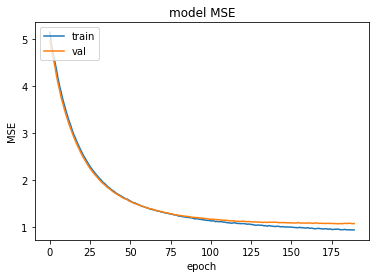

<Figure size 432x288 with 0 Axes>

In [16]:
""" Training history plot. """

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim(0.6,1)
plt.show()
plt.clf()

In [17]:
""" Save model. """
model.save("models/mass_reco_narrow_btags")

INFO:tensorflow:Assets written to: models/mass_reco_narrow_btags/assets


2022-01-04 09:04:35.789835: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


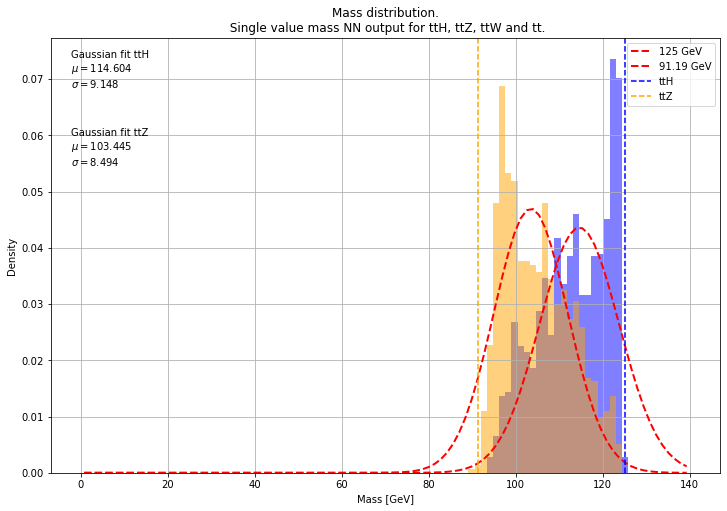

113.1393 8.114915


In [18]:
""" Pyplot histogram. """
#model = keras.models.load_model("models/mass_reco_narrow")

from scipy.optimize import curve_fit
from scipy.stats import crystalball, norm

ttH_eval_generator = DataGenerator(np.concatenate((X_y_test_ttH[:,:-10], X_y_test_ttH[:,-6:]), axis = 1), y_test_masses[:len(X_y_test_ttH)], n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)
ttZ_eval_generator = DataGenerator(np.concatenate((X_y_test_ttZ[:,:-10], X_y_test_ttZ[:,-6:]), axis = 1), y_test_masses[len(X_y_test_ttH):len(X_y_test_ttH)+len(X_y_test_ttZ)], n_features = num_features, batch_size=64, shuffle=False, augmentation = False, ceil = True)

ttH_y_pred = model.predict(ttH_eval_generator)
X_y = ttH_eval_generator.get_all()
ttH_X_eval = X_y[0]
ttH_y_true = X_y[1]

ttZ_y_pred = model.predict(ttZ_eval_generator)
X_y = ttZ_eval_generator.get_all()
ttZ_X_eval = X_y[0]
ttZ_y_true = X_y[1]


""" Scale in the opposite direction, to get the mass in MeV. """
with open("scaler_params/y_scaler_higgs_masses_narrow_btags.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    y_scaler = scaler_params[0:2]

ttH_y_true = ttH_y_true * y_scaler[1] + y_scaler[0]
ttH_y_pred = ttH_y_pred * y_scaler[1] + y_scaler[0]

ttZ_y_true = ttZ_y_true * y_scaler[1] + y_scaler[0]
ttZ_y_pred = ttZ_y_pred * y_scaler[1] + y_scaler[0]

with open("scaler_params/X_scaler_mass_reco_narrow_btags.csv") as f:
    scaler_params = np.loadtxt(f, delimiter=",")
    X_scaler = scaler_params[0:2,:]

ttH_X_eval = ttH_X_eval * X_scaler[1] + X_scaler[0]
ttZ_X_eval = ttZ_X_eval * X_scaler[1] + X_scaler[0]

predicted_higgs_masses = []
predicted_Z_masses = []

VIS_TAU_HADR_INDEX = 12
VIS_TAU_LEP_INDEX = 28

plt.figure(figsize=(12,8))

n, bins, patches = plt.hist(ttH_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='blue')
centers = (0.5*(bins[1:]+bins[:-1]))
mean,std = norm.fit(ttH_y_pred/1000)
p0 = [mean, std]
pars1, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=p0)
plt.plot(centers, norm.pdf(centers,*pars1), 'r--',linewidth = 2, label='fit before') 
plt.annotate("Gaussian fit ttH" "\n" r'$\mu=%.3f$' "\n" r'$\sigma=%.3f$' % (pars1[0], pars1[1]), xy=(0, 1), xytext=(20, -12), va='top',
	             xycoords='axes fraction', textcoords='offset points')

n, bins, patches = plt.hist(ttZ_y_pred/1000, bins=np.linspace(0,140,100), alpha = 0.5, density = True, color='orange')
centers = (0.5*(bins[1:]+bins[:-1]))
mean,std = norm.fit(ttZ_y_pred/1000)
p0 = [mean, std]
pars2, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=p0)
plt.plot(centers, norm.pdf(centers,*pars2), 'r--',linewidth = 2, label='fit before') 
plt.annotate("Gaussian fit ttZ" "\n" r'$\mu=%.3f$' "\n" r'$\sigma=%.3f$' % (pars2[0], pars2[1]), xy=(0, 1), xytext=(20, -90), va='top',
	             xycoords='axes fraction', textcoords='offset points')

plt.axvline(125,color='blue', linestyle='dashed')
plt.axvline(91.19,color='orange', linestyle='dashed')
plt.title("Mass distribution.\n Single value mass NN output for ttH, ttZ, ttW and tt.")
plt.xlabel("Mass [GeV]")
plt.ylabel("Density")
plt.legend(["125 GeV","91.19 GeV","ttH","ttZ"])
plt.grid()
plt.savefig("figures/mass_histo_narrow_pyplot_btags.pdf")
plt.show()

print(np.mean(ttH_y_pred/1000), np.std(ttH_y_pred/1000))

0.8
1.3333333333333333


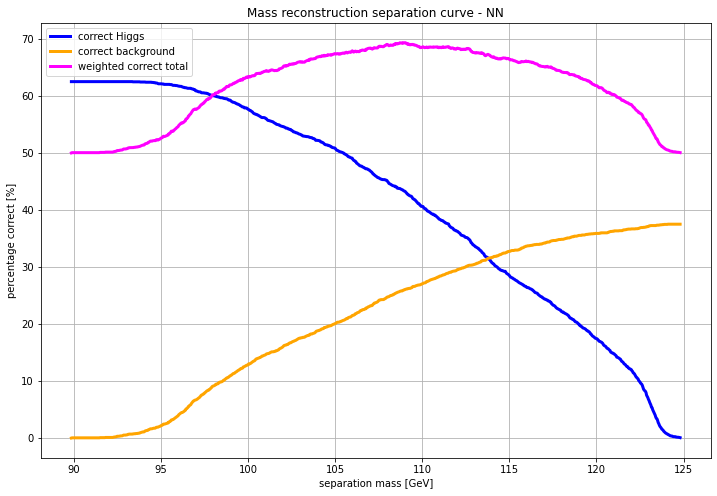

69.32966023875116


In [19]:
""" Separation curve. """

min_mass = np.min(np.concatenate((ttH_y_pred, ttZ_y_pred)))
max_mass = np.max(np.concatenate((ttH_y_pred, ttZ_y_pred)))

bg_weight = (len(ttZ_y_pred)+len(ttH_y_pred))/2/len(ttZ_y_pred)
h_weight = (len(ttZ_y_pred)+len(ttH_y_pred))/2/len(ttH_y_pred)
print(h_weight)
print(bg_weight)

n_steps = 1000
step_size = (max_mass-min_mass)/n_steps
current_divider = min_mass

correct_h = np.zeros((n_steps))
correct_bg = np.zeros((n_steps))

incorrect_h = np.zeros((n_steps))
incorrect_bg = np.zeros((n_steps))

steps = np.zeros((n_steps))

for i in range(n_steps):

    current_divider = min_mass+i*step_size
    steps[i] = current_divider

    for h_mass in ttH_y_pred:
        if h_mass < current_divider:
            incorrect_h[i] += 1
        else:
            correct_h[i] += 1

    for z_mass in ttZ_y_pred:
        if z_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1

steps = steps/1000
correct_h /= (len(ttH_y_pred)+len(ttZ_y_pred))/100
correct_bg /= (len(ttH_y_pred)+len(ttZ_y_pred))/100
plt.figure(figsize=(12,8))
plt.plot(steps, correct_h, linewidth=3, color='blue')
plt.plot(steps, correct_bg, linewidth=3, color='orange')
plt.plot(steps, h_weight*correct_h + bg_weight*correct_bg, linewidth=3, color='magenta')
plt.title("Mass reconstruction separation curve - NN")
plt.xlabel("separation mass [GeV]")
plt.ylabel("percentage correct [%]")
plt.legend(["correct Higgs","correct background","weighted correct total"])
plt.grid()
plt.savefig("figures/mass_histo_narrow_separation_btags.pdf")
plt.show()
print(np.max(h_weight*correct_h + bg_weight*correct_bg))

In [20]:
""" ROOT histogram. """
import atlasplots as aplt
import root_numpy
from ROOT import TF1, TLine

aplt.set_atlas_style()

H_line = TLine(125.18,0,125.18,1000)
H_line.SetLineStyle(9)
H_line.SetLineWidth(3)
Z_line = TLine(91.19,0,91.19,1000)
Z_line.SetLineStyle(9)
Z_line.SetLineWidth(3)

gauss_fit_1 = TF1("gauss_fit_1","gaus(0)",80,140)
gauss_fit_1.SetParameters(1, 1, 1)

gauss_fit_2 = TF1("gauss_fit_2","gaus(0)",80,140)
gauss_fit_2.SetParameters(1, 1, 1)

ttH = root.TH1F("ttH","",20,80,140)
root_numpy.fill_hist(ttH, ttH_y_pred.flatten()/1000)

weights = np.ones(len(ttZ_y_pred))*(len(ttH_y_pred)/len(ttZ_y_pred))

ttZ = root.TH1F("ttZ","",20,80,140)
root_numpy.fill_hist(ttZ, ttZ_y_pred.flatten()/1000, weights)

fig, ax = aplt.subplots(1, 1)

ttH.Fit("gauss_fit_2","0")
gauss_fit_2.SetNpx(1000)
#ax.plot(gauss_fit_2, label="Fit", labelfmt="L", linecolor=root.kRed+1, linewidth=3)

ttZ.Fit("gauss_fit_1","0")
gauss_fit_1.SetNpx(1000)
#ax.plot(gauss_fit_1, label=None, labelfmt="L", linecolor=root.kRed+1, linewidth=3)

ttH_fit = ttH.GetFunction("gauss_fit_2")
print(ttH_fit.GetParameter(0))
print(ttH_fit.GetParameter(1))
print(ttH_fit.GetParameter(2))
ax.plot(H_line, linecolor='black', label=None, labelfmt="L")
ax.plot(Z_line, linecolor='black', label=None, labelfmt="L")
ax.plot(ttH, linecolor='blue', linewidth=3, label="ttH", labelfmt="L")
ax.plot(ttZ, linecolor=807, linewidth=3, label="ttZ", labelfmt="L")
ax.set_xlim(80, 140)
ax.set_ylim(0, 380)
ax.set_xlabel("Mass [GeV]")
ax.set_ylabel("Events")
ax.add_margins(top=0.15)
ax.legend(loc=(0.77, 0.7, 0.95, 0.92))
fig.savefig("figures/mass_histo_narrow_root_btags.pdf")

Applying ATLAS style settings


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


255.951110808501
120.77051335278622
12.949265274644914
 FCN=110.989 FROM MIGRAD    STATUS=CONVERGED      95 CALLS          96 TOTAL
                     EDM=5.67833e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.55951e+02   9.86755e+00   3.20359e-02  -4.73479e-05
   2  Mean         1.20771e+02   1.43616e+00   1.97069e-03   3.79888e-04
   3  Sigma        1.29493e+01   7.33492e-01   3.98938e-05  -1.70076e-02
 FCN=206.786 FROM MIGRAD    STATUS=CONVERGED      80 CALLS          81 TOTAL
                     EDM=1.80654e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.40542e+02   9.98620e+00   5.70030e-02   2.17625e-05
   2  Mean         1.06715e+02   3.21149e-01   1.85

Info in <TCanvas::Print>: pdf file figures/mass_histo_narrow_root_btags.pdf has been created
